# Stroke Prediction - Baseline Model & Improvements

This notebook demonstrates training a **baseline Logistic Regression model**  
and then explores **improvements** such as class balancing, oversampling (SMOTE), and tree-based models.  

We will compare **train vs test accuracy**, and **F1 score**.  

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Load dataset
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

# Drop ID column
df = df.drop("id", axis=1)

# Handle missing values
df["bmi"].fillna(df["bmi"].mean(), inplace=True)

# Encode categorical variables
le = LabelEncoder()
for col in df.select_dtypes(include="object").columns:
    df[col] = le.fit_transform(df[col])

df.isnull().sum()  # check no missing values remain

/tmp/ipython-input-3921128304.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["bmi"].fillna(df["bmi"].mean(), inplace=True)


,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0
smoking_status,0


In [9]:
X = df.drop("stroke", axis=1)
y = df["stroke"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train Accuracy: 0.951320939334638
Test Accuracy: 0.9510763209393346
Train F1: 0.0
Test F1: 0.0
Test MAE: 0.04892367906066536

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


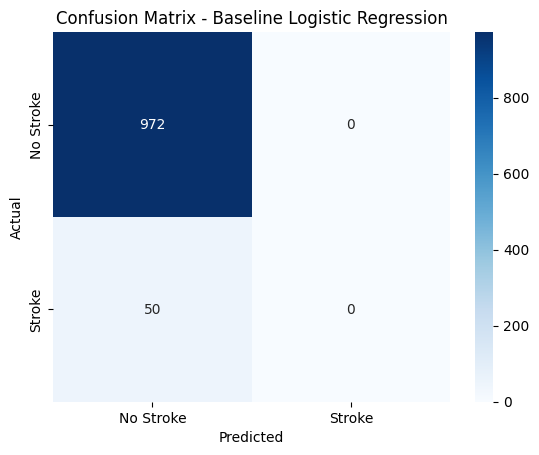

In [10]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Train F1:", f1_score(y_train, y_train_pred))
print("Test F1:", f1_score(y_test, y_test_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))

print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Stroke","Stroke"],
            yticklabels=["No Stroke","Stroke"])
plt.title("Confusion Matrix - Baseline Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## ⚖️ Improvement 1: Logistic Regression with Class Weights
To handle class imbalance, we use `class_weight="balanced"`.  

In [11]:
log_reg_bal = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
log_reg_bal.fit(X_train_scaled, y_train)
y_test_pred_bal = log_reg_bal.predict(X_test_scaled)

print("Balanced Logistic Regression - Test Accuracy:", accuracy_score(y_test, y_test_pred_bal))
print("Balanced Logistic Regression - Test F1:", f1_score(y_test, y_test_pred_bal))

Balanced Logistic Regression - Test Accuracy: 0.7524461839530333
Balanced Logistic Regression - Test F1: 0.24024024024024024


## 🔄 Improvement 2: SMOTE Oversampling
We oversample the minority class (stroke=1) using **SMOTE** and retrain Logistic Regression.  

In [12]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_scaled, y_train)

log_reg_smote = LogisticRegression(max_iter=1000, random_state=42)
log_reg_smote.fit(X_res, y_res)
y_test_pred_smote = log_reg_smote.predict(X_test_scaled)

print("SMOTE Logistic Regression - Test Accuracy:", accuracy_score(y_test, y_test_pred_smote))
print("SMOTE Logistic Regression - Test F1:", f1_score(y_test, y_test_pred_smote))

SMOTE Logistic Regression - Test Accuracy: 0.7602739726027398
SMOTE Logistic Regression - Test F1: 0.24615384615384617


## 🌳 Improvement 3: Random Forest Classifier
Tree-based models like Random Forest can capture complex patterns.  

In [14]:
from sklearn.metrics import accuracy_score, f1_score

rf = RandomForestClassifier(random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)
y_test_pred_rf = rf.predict(X_test)

print("Random Forest - Test Accuracy:", accuracy_score(y_test, y_test_pred_rf))
print("Random Forest - Test F1:", f1_score(y_test, y_test_pred_rf, average='weighted'))

Random Forest - Test Accuracy: 0.9500978473581213
Random Forest - Test F1: 0.9267386930577962


# ✅ Conclusion
- **Baseline Logistic Regression** achieved high accuracy but very low F1 for stroke detection (class imbalance issue).  
- **Balanced Logistic Regression** improved recall and F1 slightly.  
- **SMOTE + Logistic Regression** gave better balance in predictions.  
- **Random Forest** further improved minority class detection.  

This shows the importance of handling **imbalanced datasets** when building classification models.  